## Kalman Filtering


In [55]:
import Simulator
import Observation
import Statistics
import LETKalmanFilter

### Definition of forward model

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators



In [56]:
timestamp = "2021_07_29-12_52_15"

grid, simulator = Simulator.from_file(timestamp)

### Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [57]:
import numpy as np

def prior(grid, phi):
    """
    Constructing a Matern-type covariance prior with Matern-parameter phi
    where the matrix is normalized with the standard deviation
    """
    # INPUT! Bell mean
    mean = 0.0*np.ones(grid.N_x)
    # INPUT! Constant var
    var  = 0.5*np.ones(grid.N_x)

    # Matern covariance
    dist_mat = np.copy(grid.dist_mat)
    cov = (1+phi*dist_mat)*np.exp(-phi*dist_mat)
    
    # Normalisation
    var_mesh = np.meshgrid(np.sqrt(var),np.sqrt(var))[0]*np.meshgrid(np.sqrt(var),np.sqrt(var))[1]    

    return mean, var_mesh, cov

Please remember to set priors!


c:\Users\florianb\Documents\advectionDiffusion\Ensemble.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  self.ensemble = np.random.multivariate_normal(mean, cov + nugget*np.eye(self.simulator.grid.N_x), self.N_e).transpose()


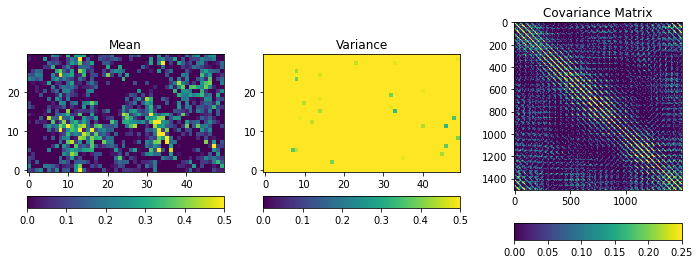

In [58]:
statistics = Statistics.Statistics(simulator, 25)
mean, var_mesh, cov = prior(grid=grid, phi=5.0)
statistics.set(mean, var_mesh*cov, nugget=0.5)
statistics.plot()

### Observations

In [59]:
observation = Observation.from_file(simulator)

Remember to set observation positions and to set values!


In [60]:
from matplotlib import pyplot as plt

In [61]:
letkFilter = LETKalmanFilter.LETKalman(statistics, observation, 5)

In [62]:
idx = 0

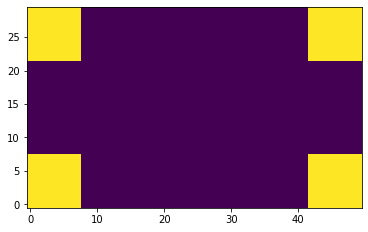

In [63]:
plt.imshow(letkFilter.all_Ls[idx], origin="lower")

In [64]:
X_f = np.zeros((statistics.ensemble.N_e, grid.ny, grid.nx))
for e in range(X_f.shape[0]):
    X_f[e] = np.reshape(statistics.ensemble.ensemble[:,e], (grid.ny, grid.nx))

In [65]:
X_f_mean = np.average(X_f, axis=0)
X_f_pert = X_f - X_f_mean

In [66]:
X_a = np.zeros_like(X_f)

In [67]:
N_x_local = letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1] 

L = letkFilter.all_Ls[idx]
xroll = letkFilter.all_xrolls[idx]
yroll = letkFilter.all_yrolls[idx]

In [68]:
X_f_loc = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc[:,:] = X_f[:,L]          

In [69]:
X_f_loc_pert = np.zeros((statistics.ensemble.N_e, N_x_local))
X_f_loc_pert[:,:] = X_f_pert[:,L]

In [70]:
X_f_loc_mean = np.zeros((N_x_local))
X_f_loc_mean[:] = X_f_mean[L]

In [71]:
if not (xroll == 0 and yroll == 0):
    rolling_shape = (statistics.ensemble.N_e, letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 2 and 3
    X_f_loc[:,:] = np.roll(np.roll(X_f_loc.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))
    X_f_loc_pert[:,:] = np.roll(np.roll(X_f_loc_pert.reshape(rolling_shape), shift=-yroll, axis=1 ), shift=-xroll, axis=2).reshape((statistics.ensemble.N_e, N_x_local))

    mean_rolling_shape = (letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1]) # roll around axis 1 and 2
    X_f_loc_mean[:] = np.roll(np.roll(X_f_loc_mean.reshape(mean_rolling_shape), shift=-yroll, axis=0 ), shift=-xroll, axis=1).reshape((N_x_local))

In [72]:
X_a_loc = X_f_loc.T

In [73]:
# Calculate weighted local analysis
weighted_X_a_loc = X_a_loc[:,:]*(np.tile(letkFilter.W_loc.flatten().T, (statistics.ensemble.N_e, 1)).T)
# Here, we use np.tile(W_loc.flatten().T, (N_e_active, 1)).T to repeat W_loc as column vector N_e_active times 

if not (xroll == 0 and yroll == 0):
    weighted_X_a_loc = np.roll(np.roll(weighted_X_a_loc[:,:].reshape((letkFilter.W_loc.shape[0], letkFilter.W_loc.shape[1], statistics.ensemble.N_e)), 
                                                                    shift=yroll, axis=0 ), 
                                    shift=xroll, axis=1)

X_a[:,L] += weighted_X_a_loc.reshape(letkFilter.W_loc.shape[0]*letkFilter.W_loc.shape[1], statistics.ensemble.N_e).T

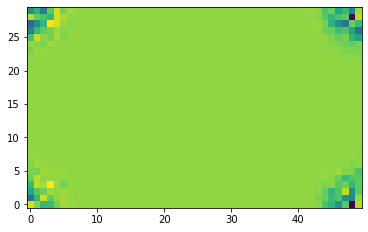

In [74]:
plt.imshow(X_a[0], origin="lower")

In [75]:
X_new = np.zeros_like(X_a)
for e in range(statistics.ensemble.N_e):
    X_new[e] = letkFilter.W_forecast*X_f[e] + X_a[e]

In [77]:
statistics.ensemble.ensemble.shape

(1500, 25)

(1500, 25)


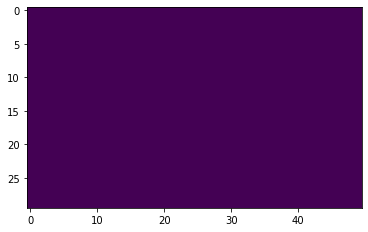

In [78]:
X_new = np.reshape(X_new, (25,1500)).T
print(X_new.shape)
plt.imshow(np.reshape(X_new[:,0], (grid.ny, grid.nx)))